<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/vito/STEP_3A_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependency & DeepLab

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from google.colab import drive
import os

!git clone -b vito --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 98 (delta 26), reused 8 (delta 8), pack-reused 41 (from 1)
Receiving objects: 100% (98/98), 18.40 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Mounted at /content/drive


In [3]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [4]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [5]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = (512, 512)

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

IGNORE_INDEX = -1

# Define and instantiate

### Define PIDnet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Instantiate model

In [8]:
import gdown
#import requests
#import tarfile

#if (os.path.exists("./pidnet.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/pidnet.py"
#  output_file = "./pidnet.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet model downloaded")
#
#if (os.path.exists("./model_utils.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/model_utils.py"
#  output_file = "./model_utils.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet utils downloaded")


if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device


Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet_S_ImageNet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 179MB/s]


imagenet-pretrained pidnet weights downloaded


device(type='cpu')

# Dataset & dataloader

## Dataset definition

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        #self.boundary_transform = boundary_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")  # Assicura che sia RGB
        mask = Image.open(mask_path).convert("L")  # Converti la maschera in scala di grigi (1 canale)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
          mask = self.target_transform(mask)

        mask_np = np.array(mask)

        #mask_grayscale = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        #if self.target_transform:
        #  boundaries = self.boundary_transform(boundaries)

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        return image, mask, boundaries_tensor  # Return (image, mask) pair

## Dataset instantiation

In [10]:
# Define transformations for images & masks
image_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.BILINEAR),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks to 256x256
])

#boundary_transform = transforms.Compose([
#    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks to 256x256
#])

# Create dataset objects
DOMAIN_SHIFT = True

train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=image_transform, target_transform=mask_transform)
if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=image_transform, target_transform= mask_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=image_transform, target_transform= mask_transform)

## Loader instantiation

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([16, 3, 512, 512]) torch.Size([16, 512, 512]) torch.Size([16, 512, 512])


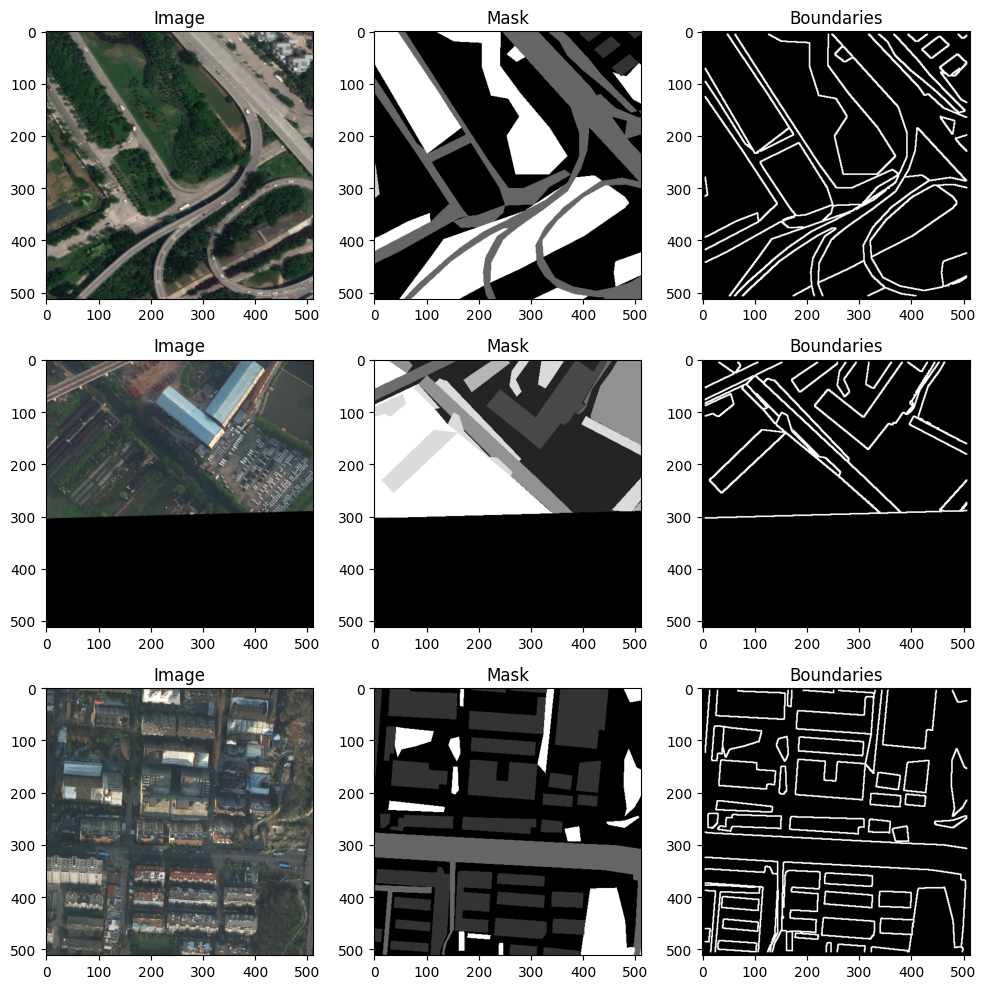

In [12]:
from utils import show
from matplotlib import pyplot as plt

print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape)

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images
    axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")

plt.tight_layout()
plt.show()

# Training Phase

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
        self.num_outputs = num_outputs
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights

    def _forward(self, pred, target):
        return self.loss(pred, target)

    def forward(self, score, target):

        if self.num_outputs == 1:
            score = [score]

        if len(self.balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
        elif len(score) == 1:
            return self.sb_weights * self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")


# Weighted Binary Cross Entropy per i bordi
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce = 20.0):
        super(BondaryLoss, self).__init__()
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):

        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        loss = bce_loss

        return loss

# PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.sem_loss = CrossEntropyLoss(num_outputs=2, balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3)
        self.bd_loss = BondaryLoss(coeff_bce=lambda_1)

        self.threshold = threshold


    def forward(self, pred_p, pred_main, target, boundary_head, boundary_mask):
        """
        pred_p: output branch P (B, C, H, W)
        pred_main: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """

        loss_s = self.sem_loss([pred_p, pred_main], target) # l_0 e l_2
        loss_b = self.bd_loss(boundary_head, boundary_mask.unsqueeze(1)) # l_1

        # l_3
        filler = torch.ones_like(target) * IGNORE_INDEX
        bd_label = torch.where(F.sigmoid(boundary_head[:,0,:,:])>self.threshold, target, filler)
        loss_sb = self.sem_loss([pred_main], bd_label)


        loss = loss_s + loss_b + loss_sb


        return loss

In [15]:
batch = next(iter(train_loader))  # (images, masks, boundaries)
X, y, boundaries = batch  # Unpack the batch
X = X.to(device)
y = y.to(device)

print("X =", X.shape)
print("y =", y.shape)
print("boundary =", boundaries.shape)

# Output del modello
outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

# Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
# Quindi passiamo da 64 x 64 a 512 x 512
h, w = boundaries.size(1), boundaries.size(2)
ph, pw = outputs[0].size(2), outputs[0].size(3)
if ph != h or pw != w:
    for i in range(len(outputs)):
        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

pred_p, pred_main, boundary_head = outputs  # P, I, D branches

#print("outputs[0] =", outputs[0].shape) # pred_p
print("outputs[1] =", outputs[1].shape) # pred_main
print("outputs[2] =", outputs[2].shape) # Ramo D (boundary_head)

preds = torch.argmax(pred_main, dim=1)
print("preds =", preds.shape)

print("unique values preds :", preds.unique())
print("unique values y :", y.unique())


X = torch.Size([16, 3, 512, 512])
y = torch.Size([16, 512, 512])
boundary = torch.Size([16, 512, 512])
outputs[1] = torch.Size([16, 7, 512, 512])
outputs[2] = torch.Size([16, 1, 512, 512])
preds = torch.Size([16, 512, 512])
unique values preds : tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
unique values y : tensor([-1,  0,  1,  2,  3,  4,  5,  6], device='cuda:0')


In [16]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU
import torch.nn.functional as F

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)
loss_fn = PIDNetLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    total_train_samples = 0

    batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

    for batch, (X, y, boundary_mask) in batch_pbar:
        X = X.to(device)
        y = y.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

        # Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
        # Quindi passiamo da 64 x 64 della rete a 512 x 512
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs  # P, I, D branches
        else:
            pred_main = outputs
            boundary_head = None  # Nessuna branch D se augment=False

        # Calcolo della loss
        loss = loss_fn(pred_p, pred_main, y, boundary_head, boundary_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_samples += X.size(0)

        train_loss += loss.item()
        batch_pbar.set_postfix(loss=loss.item())

    #avg_train_loss = train_loss / len(train_loader)

    #total_samples = sum(len(batch[0]) for batch in train_loader)
    avg_train_loss = train_loss / total_train_samples


    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")


    # **Validazione**
    model.eval()
    val_loss = 0
    miou_classes.reset()
    total_val_samples = 0

    with torch.inference_mode():
        for X_val, y_val, boundary_mask in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            boundary_mask = boundary_mask.to(device)

            # Output del modello
            outputs = model(X_val)

            ## Upscale trough bilinear interpolation
            h, w = boundary_mask.size(1), boundary_mask.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
                for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

            if model.augment:
                pred_p, pred_main, boundary_head = outputs
            else:
                pred_main = outputs
                boundary_head = None

            # Calcola la loss
            loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

            val_loss += loss.item()

            total_val_samples += X_val.size(0)

            # Calcola le predizioni
            preds = pred_main.argmax(dim=1)  # Shape: (N, H, W)

            # Mask dei pixel validi (classi da 0 a num_classes - 1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)

            # Appiattisci le predizioni e i target solo sui pixel validi
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)

    avg_val_loss = val_loss / total_val_samples

    miou_per_class = miou_classes.compute()  # Returns a tensor with per-class IoU
    miou = miou_per_class.mean()

    miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
    #print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou_score:.4f}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou} - mIoU per class {miou_per_class_str}")

    if epoch % 5 == 0:
      print(scheduler.get_last_lr())


    ## steps the scheduler
    scheduler.step()


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:19<00:00,  3.65it/s, loss=8.27]

Epoch 1/20 - Training Loss: 0.5023087415728189


Epoch 1/20 - Validation Loss: 0.39184964568384234 - mIoU: 0.1429501324892044 - mIoU per class Class 0: 0.3559, Class 1: 0.1954, Class 2: 0.1195, Class 3: 0.1774, Class 4: 0.0328, Class 5: 0.0856, Class 6: 0.0340
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=5.07]

Epoch 2/20 - Training Loss: 0.3164044853725235


Epoch 2/20 - Validation Loss: 0.34621284950164055 - mIoU: 0.1696052849292755 - mIoU per class Class 0: 0.3515, Class 1: 0.2790, Class 2: 0.1459, Class 3: 0.2465, Class 4: 0.0342, Class 5: 0.0827, Class 6: 0.0474


Epoch 3/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.63it/s, loss=4.7]

Epoch 3/20 - Training Loss: 0.291537285676052


Epoch 3/20 - Validation Loss: 0.32989528967488196 - mIoU: 0.20163188874721527 - mIoU per class Class 0: 0.3805, Class 1: 0.3055, Class 2: 0.1925, Class 3: 0.2993, Class 4: 0.0287, Class 5: 0.0809, Class 6: 0.1240


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=5.98]

Epoch 4/20 - Training Loss: 0.28411961014295534


Epoch 4/20 - Validation Loss: 0.3312874868992836 - mIoU: 0.20465527474880219 - mIoU per class Class 0: 0.3996, Class 1: 0.3364, Class 2: 0.2144, Class 3: 0.2490, Class 4: 0.0310, Class 5: 0.0710, Class 6: 0.1312


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=4.26]

Epoch 5/20 - Training Loss: 0.2708416727587426


Epoch 5/20 - Validation Loss: 0.3233304884164564 - mIoU: 0.22356057167053223 - mIoU per class Class 0: 0.3778, Class 1: 0.3063, Class 2: 0.2348, Class 3: 0.3185, Class 4: 0.0305, Class 5: 0.0795, Class 6: 0.2175


Epoch 6/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=5.9]

Epoch 6/20 - Training Loss: 0.2670831067751848


Epoch 6/20 - Validation Loss: 0.3238385372584866 - mIoU: 0.2364310622215271 - mIoU per class Class 0: 0.4038, Class 1: 0.3201, Class 2: 0.2425, Class 3: 0.3333, Class 4: 0.0307, Class 5: 0.0930, Class 6: 0.2316
[0.001]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=5.38]

Epoch 7/20 - Training Loss: 0.2661396244405463


Epoch 7/20 - Validation Loss: 0.3275993052990206 - mIoU: 0.2353256344795227 - mIoU per class Class 0: 0.4258, Class 1: 0.2984, Class 2: 0.2430, Class 3: 0.3275, Class 4: 0.0272, Class 5: 0.0786, Class 6: 0.2468


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=3.76]

Epoch 8/20 - Training Loss: 0.26205922039322377


Epoch 8/20 - Validation Loss: 0.32632509450758657 - mIoU: 0.22586050629615784 - mIoU per class Class 0: 0.4122, Class 1: 0.2968, Class 2: 0.2434, Class 3: 0.2959, Class 4: 0.0284, Class 5: 0.0773, Class 6: 0.2270


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=7.04]

Epoch 9/20 - Training Loss: 0.26529843666974234


Epoch 9/20 - Validation Loss: 0.3288145714229153 - mIoU: 0.2337760627269745 - mIoU per class Class 0: 0.4055, Class 1: 0.3121, Class 2: 0.2454, Class 3: 0.3343, Class 4: 0.0300, Class 5: 0.0796, Class 6: 0.2297


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.64it/s, loss=5.79]

Epoch 10/20 - Training Loss: 0.26329677059576173


Epoch 10/20 - Validation Loss: 0.3278599318958098 - mIoU: 0.23236167430877686 - mIoU per class Class 0: 0.4145, Class 1: 0.2805, Class 2: 0.2474, Class 3: 0.3421, Class 4: 0.0319, Class 5: 0.0820, Class 6: 0.2281


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=4.57]

Epoch 11/20 - Training Loss: 0.2617197290423832


Epoch 11/20 - Validation Loss: 0.3274013087634117 - mIoU: 0.21931353211402893 - mIoU per class Class 0: 0.4052, Class 1: 0.3182, Class 2: 0.2480, Class 3: 0.2688, Class 4: 0.0284, Class 5: 0.0762, Class 6: 0.1904
[0.0001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=4.84]

Epoch 12/20 - Training Loss: 0.2594834601177889


Epoch 12/20 - Validation Loss: 0.3246552425046121 - mIoU: 0.23356640338897705 - mIoU per class Class 0: 0.4126, Class 1: 0.3127, Class 2: 0.2534, Class 3: 0.2799, Class 4: 0.0290, Class 5: 0.0812, Class 6: 0.2661


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=4.72]

Epoch 13/20 - Training Loss: 0.26211083017831033


Epoch 13/20 - Validation Loss: 0.3268369965014919 - mIoU: 0.22416535019874573 - mIoU per class Class 0: 0.3941, Class 1: 0.3164, Class 2: 0.2534, Class 3: 0.2295, Class 4: 0.0287, Class 5: 0.0750, Class 6: 0.2719


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=3.68]

Epoch 14/20 - Training Loss: 0.2603118256714105


Epoch 14/20 - Validation Loss: 0.3203285639324496 - mIoU: 0.23457540571689606 - mIoU per class Class 0: 0.4078, Class 1: 0.3052, Class 2: 0.2470, Class 3: 0.2839, Class 4: 0.0299, Class 5: 0.0847, Class 6: 0.2836


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.64it/s, loss=4.09]

Epoch 15/20 - Training Loss: 0.26147853317557734


Epoch 15/20 - Validation Loss: 0.3203464592656782 - mIoU: 0.23170000314712524 - mIoU per class Class 0: 0.4220, Class 1: 0.2896, Class 2: 0.2522, Class 3: 0.2803, Class 4: 0.0298, Class 5: 0.0778, Class 6: 0.2703


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=6.26]

Epoch 16/20 - Training Loss: 0.2602962329725906


Epoch 16/20 - Validation Loss: 0.3252137524466361 - mIoU: 0.2354346513748169 - mIoU per class Class 0: 0.4004, Class 1: 0.3148, Class 2: 0.2538, Class 3: 0.2919, Class 4: 0.0313, Class 5: 0.0853, Class 6: 0.2706
[1e-05]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=3.66]

Epoch 17/20 - Training Loss: 0.25960536151608793


Epoch 17/20 - Validation Loss: 0.3202403240626858 - mIoU: 0.2390977144241333 - mIoU per class Class 0: 0.4100, Class 1: 0.3071, Class 2: 0.2510, Class 3: 0.2802, Class 4: 0.0309, Class 5: 0.0896, Class 6: 0.3049


Epoch 18/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=4.3]

Epoch 18/20 - Training Loss: 0.25986257185160494


Epoch 18/20 - Validation Loss: 0.33023798129250925 - mIoU: 0.22837954759597778 - mIoU per class Class 0: 0.3948, Class 1: 0.3296, Class 2: 0.2513, Class 3: 0.2726, Class 4: 0.0293, Class 5: 0.0756, Class 6: 0.2455


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.63it/s, loss=5.23]

Epoch 19/20 - Training Loss: 0.26250910923967724


Epoch 19/20 - Validation Loss: 0.32250607830862843 - mIoU: 0.23863203823566437 - mIoU per class Class 0: 0.4161, Class 1: 0.3062, Class 2: 0.2500, Class 3: 0.3133, Class 4: 0.0326, Class 5: 0.0853, Class 6: 0.2669


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.64it/s, loss=4.43]

Epoch 20/20 - Training Loss: 0.26129982504465177


Epoch 20/20 - Validation Loss: 0.321565528069773 - mIoU: 0.2339749038219452 - mIoU per class Class 0: 0.4081, Class 1: 0.3243, Class 2: 0.2577, Class 3: 0.2787, Class 4: 0.0272, Class 5: 0.0787, Class 6: 0.2631


In [19]:
# **Validazione**
model.eval()
val_loss = 0
miou_classes.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Calcola la loss
        loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        # Calcola le predizioni
        preds = pred_main.argmax(dim=1)  # Shape: (N, H, W)

        # Mask dei pixel validi (classi da 0 a num_classes - 1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)

        # Appiattisci le predizioni e i target solo sui pixel validi
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        miou_classes.update(preds_flat, targets_flat)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()  # Returns a tensor with per-class IoU
miou = miou_per_class.mean()

miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
#print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou_score:.4f}")
print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou} - mIoU per class {miou_per_class_str}")

Epoch 20/20 - Validation Loss: 0.32156552614704254 - mIoU: 0.2339749038219452 - mIoU per class Class 0: 0.4081, Class 1: 0.3243, Class 2: 0.2577, Class 3: 0.2787, Class 4: 0.0272, Class 5: 0.0787, Class 6: 0.2631


### Salvataggio del modello su drive

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

## Stats

*********


FLOPs: 6.317 GFLOPs
Average inference latency is 0.061 seconds.


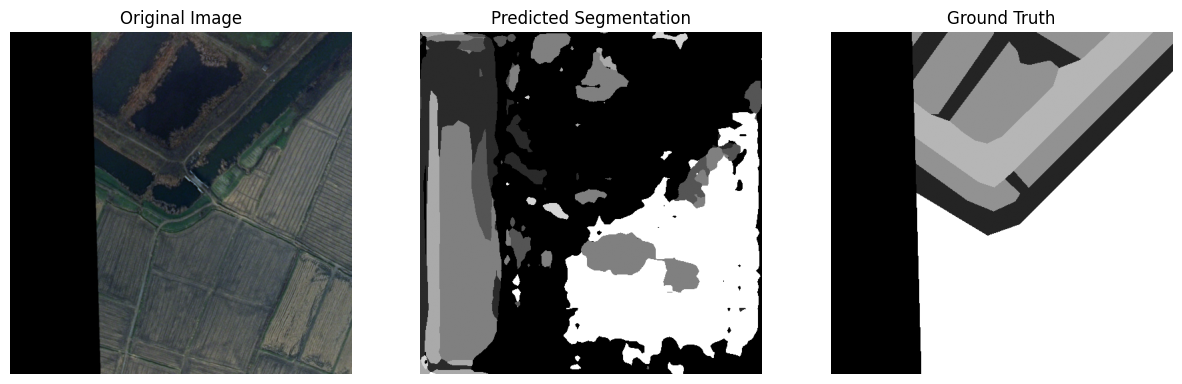

Params: 7.718 M


In [20]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print("*********")
    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
